# Data Wrangling Project

In [15]:
# Load datasets
import pandas as pd


try:
    invoices_df = pd.read_csv("synthetic_invoices.csv")
    vials_df = pd.read_csv("synthetic_vials.csv")
    dispense_log_df = pd.read_csv("synthetic_dispense_log.csv")
    claims_df = pd.read_csv("synthetic_claims.csv")
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Please ensure all CSV files are in the correct directory.")
    raise


## Data Collection

In [16]:
# Clean 'Purchase Price' in vials_df
vials_df['Purchase Price'] = vials_df['Purchase Price'].replace({'\$': ''}, regex=True).astype(float)

# Merge datasets
vial_invoice_df = pd.merge(vials_df, invoices_df, on="Invoice Number", how="left")
full_df = pd.merge(vial_invoice_df, dispense_log_df, on="Vial Number", how="left")
full_df = pd.merge(full_df, claims_df, on="Dispense ID", how="left")


<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Asus\AppData\Local\Temp\ipykernel_5308\2450867129.py:2: SyntaxWarning: invalid escape sequence '\$'
  vials_df['Purchase Price'] = vials_df['Purchase Price'].replace({'\$': ''}, regex=True).astype(float)


## Data Organization

In [17]:
# Analyze and report
print("--- Ophthalmology Drug Tracking Analysis ---")

# 1. Identify Unscanned Vials
unscanned_vials = full_df[full_df['Unscanned'] == True]
print(f"\n## Unscanned Vials Report ({len(unscanned_vials)} found)")
if not unscanned_vials.empty:
    print("The following vials were dispensed but not scanned, leading to potential revenue loss:")
    print(unscanned_vials[['Vial Number', 'Lot Number', 'Purchase Price', 'Dispense ID', 'Patient ID', 'Date Of Dispense', 'Username']])
else:
    print("No unscanned vials found.")

# 2. Identify Denied Claims
denied_claims = full_df[full_df['Denied'] == True]
print(f"\n## Denied Claims Report ({len(denied_claims)} found)")
if not denied_claims.empty:
    print("The following claims were denied by insurance:")
    print(denied_claims[['Claim ID', 'Dispense ID', 'Vial Number', 'Patient ID', 'Claim Date', 'Amount']])
else:
    print("No denied claims found.")

# 3. Profitability Analysis
reimbursed_claims = full_df[(full_df['Denied'] == False) & (full_df['Amount'].notna())]
reimbursed_claims['Profit'] = reimbursed_claims['Amount'] - reimbursed_claims['Purchase Price']

total_revenue = reimbursed_claims['Amount'].sum()
total_cost = reimbursed_claims['Purchase Price'].sum()
total_profit = reimbursed_claims['Profit'].sum()

print("\n## Profitability Analysis")
print(f"Total Revenue from Reimbursed Claims: ${total_revenue:,.2f}")
print(f"Total Cost of Goods Sold: ${total_cost:,.2f}")
print(f"Total Profit: ${total_profit:,.2f}")

if not reimbursed_claims.empty:
    print("\n### Top 5 Most Profitable Vials:")
    print(reimbursed_claims.nlargest(5, 'Profit')[['Vial Number', 'Purchase Price', 'Amount', 'Profit']])
    print("\n### Top 5 Least Profitable Vials:")
    print(reimbursed_claims.nsmallest(5, 'Profit')[['Vial Number', 'Purchase Price', 'Amount', 'Profit']])


--- Ophthalmology Drug Tracking Analysis ---

## Unscanned Vials Report (622 found)
The following vials were dispensed but not scanned, leading to potential revenue loss:
      Vial Number   Lot Number  Purchase Price  Dispense ID  Patient ID  \
6      VN-0000005  LOT-8583121            50.0  DISP-010328    567386.0   
34     VN-0000025  LOT-5251569            50.0  DISP-003474    930415.0   
50     VN-0000038  LOT-1985938            50.0  DISP-002492    435402.0   
71     VN-0000050  LOT-8239582            50.0  DISP-007851    722927.0   
77     VN-0000056  LOT-1894126            50.0  DISP-000043    702136.0   
...           ...          ...             ...          ...         ...   
15618  VN-0011891  LOT-1987565            50.0  DISP-000017    516499.0   
15639  VN-0011906  LOT-6786924            50.0  DISP-000179    394925.0   
15643  VN-0011910  LOT-7320978            50.0  DISP-005509    882115.0   
15703  VN-0011959  LOT-3824453            50.0  DISP-006094    820014.0   
1573

C:\Users\Asus\AppData\Local\Temp\ipykernel_5308\95804216.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reimbursed_claims['Profit'] = reimbursed_claims['Amount'] - reimbursed_claims['Purchase Price']


## Data Cleaning

In [18]:
# Checked for duplicates
duplicates = full_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Removed duplicates
if duplicates > 0:
    full_df = full_df.drop_duplicates()
    print("Duplicates removed.")
else:
    print("No duplicates found.")

# Checked for missing values
missing_values = full_df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

# Handled missing values
full_df.fillna(method='ffill', inplace=True)
print("Missing values handled.")


Number of duplicate rows: 0
No duplicates found.
Missing values in each column:
Dispense ID         4754
Patient ID          4754
Date Of Dispense    4754
Username            4754
Unscanned           4754
Claim ID            4754
Claim Date          4754
Amount              4754
Denied              4754
dtype: int64
Missing values handled.


C:\Users\Asus\AppData\Local\Temp\ipykernel_5308\1028476138.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df.fillna(method='ffill', inplace=True)


# EDA FUNDAMENTALS

In [19]:
# Import necessary libraries for EDA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")

In [20]:
# Display descriptive statistics for numerical columns
print("--- Descriptive Statistics for Numerical Features ---")
print(full_df.describe())

print("\n--- DataFrame Info ---")
full_df.info()

print("\n--- Value Counts for Categorical Features ---")
print("\nUnscanned Vials:")
print(full_df['Unscanned'].value_counts(normalize=True))

print("\nDenied Claims:")
print(full_df['Denied'].value_counts(normalize=True))

--- Descriptive Statistics for Numerical Features ---
       Purchase Price  Total Amount     Patient ID        Amount
count         15754.0  15754.000000   15753.000000  15753.000000
mean             50.0   2746.863912  551742.635054    130.351054
std               0.0   1279.527817  259596.098293     40.528138
min              50.0    500.170000  100033.000000     60.010000
25%              50.0   1646.940000  325285.000000     95.560000
50%              50.0   2758.380000  554084.000000    130.280000
75%              50.0   3820.770000  777542.000000    165.480000
max              50.0   4998.820000  999868.000000    199.980000

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15754 entries, 0 to 15753
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Vial Number       15754 non-null  object 
 1   Lot Number        15754 non-null  object 
 2   Expiration Date   15754 non-null  o

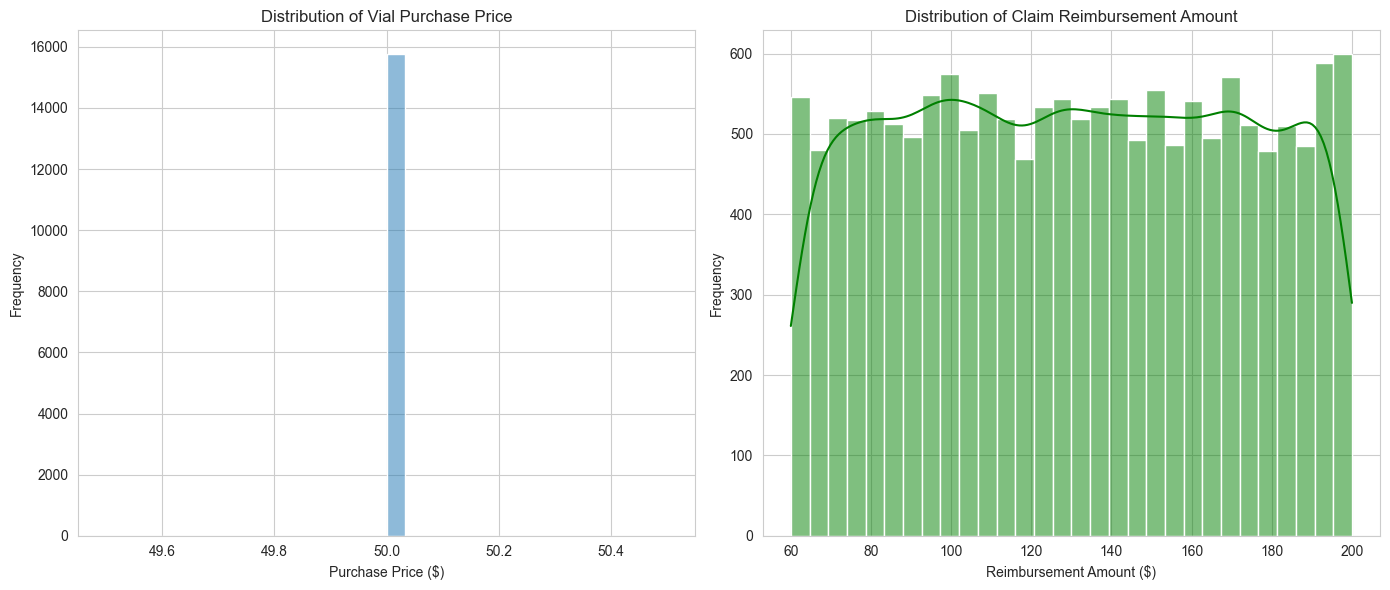

In [21]:
# 1. Distribution of Key Numerical Features
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(full_df['Purchase Price'], kde=True, bins=30)
plt.title('Distribution of Vial Purchase Price')
plt.xlabel('Purchase Price ($)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(full_df[full_df['Amount'].notna()]['Amount'], kde=True, bins=30, color='green')
plt.title('Distribution of Claim Reimbursement Amount')
plt.xlabel('Reimbursement Amount ($)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

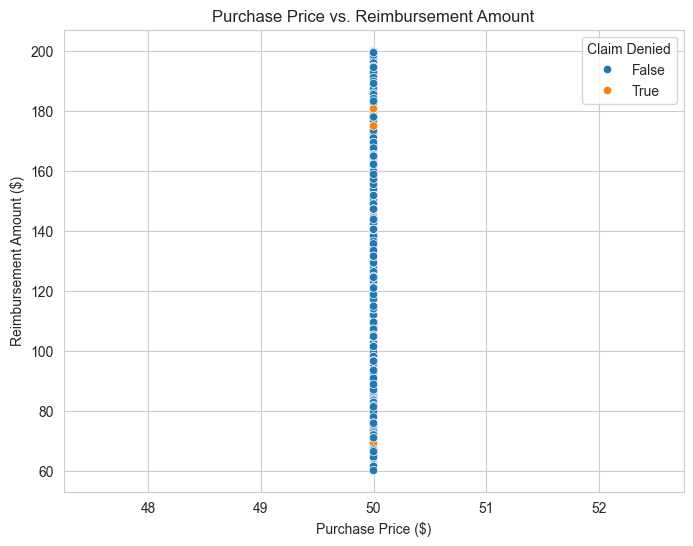

In [22]:
# 2. Relationship between Purchase Price and Reimbursement Amount
plt.figure(figsize=(8, 6))
sns.scatterplot(data=full_df, x='Purchase Price', y='Amount', hue='Denied')
plt.title('Purchase Price vs. Reimbursement Amount')
plt.xlabel('Purchase Price ($)')
plt.ylabel('Reimbursement Amount ($)')
plt.legend(title='Claim Denied')
plt.show()

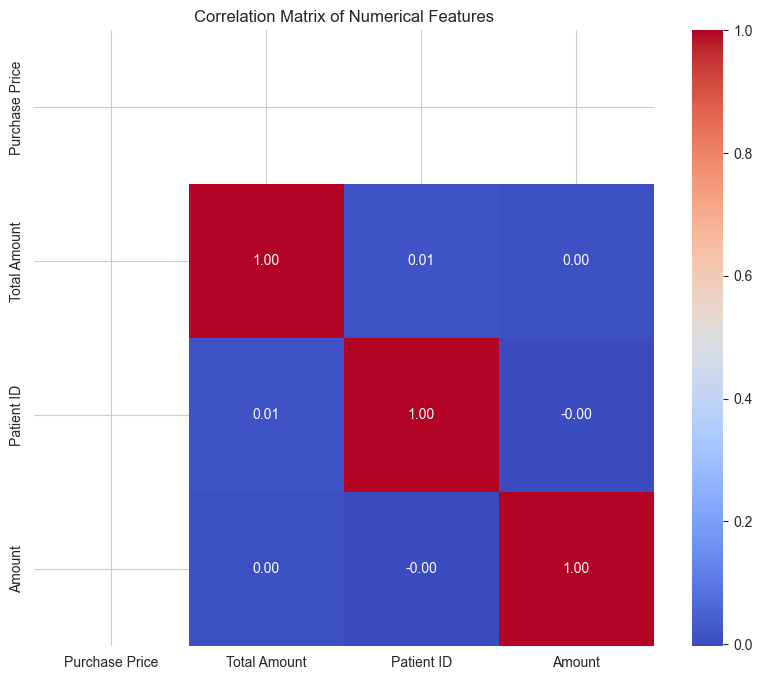

In [23]:
# 3. Correlation Heatmap
plt.figure(figsize=(10, 8))
numeric_cols = full_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = full_df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [24]:
# Prepared the data for the t-test
approved_claims_amount = full_df[(full_df['Denied'] == False) & (full_df['Amount'].notna())]['Amount']
denied_claims_amount = full_df[(full_df['Denied'] == True) & (full_df['Amount'].notna())]['Amount']

t_stat, p_value = stats.ttest_ind(approved_claims_amount, denied_claims_amount, equal_var=False, nan_policy='omit')

print("--- Hypothesis Test: Approved vs. Denied Claim Amounts ---")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("\nConclusion: We reject the null hypothesis.")
    print("There is a statistically significant difference in reimbursement amounts between approved and denied claims.")
else:
    print("\nConclusion: We fail to reject the null hypothesis.")
    print("There is no statistically significant difference in reimbursement amounts between approved and denied claims.")

--- Hypothesis Test: Approved vs. Denied Claim Amounts ---
T-statistic: 0.0213
P-value: 0.9831

Conclusion: We fail to reject the null hypothesis.
There is no statistically significant difference in reimbursement amounts between approved and denied claims.


--- Feature Engineering: Profit Margin ---
Top 5 Vials by Profit Margin:
      Vial Number  Purchase Price  Amount  Profit  Profit Margin
15     VN-0000010            50.0  199.98  149.98      74.997500
16     VN-0000011            50.0  199.98  149.98      74.997500
17     VN-0000012            50.0  199.98  149.98      74.997500
2695   VN-0002064            50.0  199.96  149.96      74.994999
13870  VN-0010556            50.0  199.94  149.94      74.992498


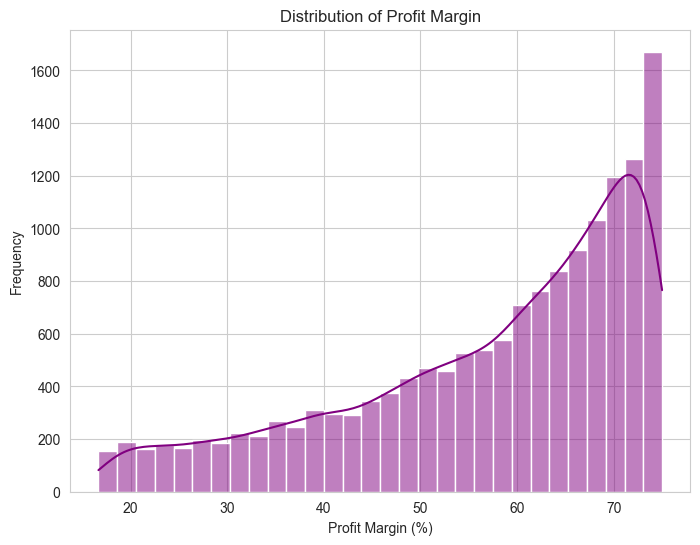

In [25]:
# Adding 'Profit Margin' feature
reimbursed_claims = full_df[(full_df['Denied'] == False) & (full_df['Amount'].notna()) & (full_df['Amount'] > 0)].copy()
reimbursed_claims['Profit'] = reimbursed_claims['Amount'] - reimbursed_claims['Purchase Price']
reimbursed_claims['Profit Margin'] = (reimbursed_claims['Profit'] / reimbursed_claims['Amount']) * 100

print("--- Feature Engineering: Profit Margin ---")
print("Top 5 Vials by Profit Margin:")
print(reimbursed_claims.nlargest(5, 'Profit Margin')[['Vial Number', 'Purchase Price', 'Amount', 'Profit', 'Profit Margin']])

plt.figure(figsize=(8, 6))
sns.histplot(reimbursed_claims['Profit Margin'], kde=True, bins=30, color='purple')
plt.title('Distribution of Profit Margin')
plt.xlabel('Profit Margin (%)')
plt.ylabel('Frequency')
plt.show()